In [ ]:
!pip uninstall -y research-common
!pip install git+https://gitlab.wikimedia.org/repos/research/research-common.git

In [ ]:
from research_common.spark import create_yarn_spark_session
from pyspark.sql import functions as F

conf =  {
    "spark.dynamicAllocation.maxExecutors": 50,
    "spark.executor.cores": 4,
    "spark.sql.shuffle.partitions": 999,
    "spark.executor.memory": "14g",
    "spark.executor.memoryOverhead": "2g",
}
spark = create_yarn_spark_session(app_id='knowledge_gaping',extra_config=conf)

# Knowledge gaps 
Knowledge gap related datasets are stored the `content_gap_metrics` hive table.

## Content gap metrics  

The content gap metrics are available at different aggregation levels. 
- by category: metrics for each category of each gap for each wiki (highest granularity)
- by content gap: metrics for each content gap for each wiki (aggregated across all categories of a gap)
- by category for all wikis: metrics for each category of each gap (aggregated across all wikis)
- by content gap for all wikis: metrics for each content gap (aggregated across all categories of a gap, and across all wikis)

All of these datasets have the following columns:
- `time_bucket`, indicating the month e.g. `2023-06`
- `metrics`, a struct containing the metrics, e.g. `{article_created:23, pageviews: 52206, revision_count, 1922, standard_quality_count:533, ...}`
- `quantiles`, a struct containing the [0.05, 0.25, 0.5, 0.75, 0.95] quantiles of certain metrics, e.g. `{revision_count: [5,17,526,1438,1600], ...}`


The schema for the most granular dataset is:

In [4]:
spark.table("content_gap_metrics.by_category").cache().printSchema()

root
 |-- wiki_db: string (nullable = true)
 |-- category: string (nullable = true)
 |-- metrics: struct (nullable = true)
 |    |-- article_created: long (nullable = true)
 |    |-- pageviews_sum: long (nullable = true)
 |    |-- pageviews_mean: double (nullable = true)
 |    |-- standard_quality: double (nullable = true)
 |    |-- standard_quality_count: long (nullable = true)
 |    |-- quality_score: double (nullable = true)
 |    |-- revision_count: long (nullable = true)
 |-- quantiles: struct (nullable = true)
 |    |-- article_created: struct (nullable = true)
 |    |    |-- 5th_percentile: integer (nullable = true)
 |    |    |-- 25th_percentile: integer (nullable = true)
 |    |    |-- median: integer (nullable = true)
 |    |    |-- 75th_percentile: integer (nullable = true)
 |    |    |-- 95th_percentile: integer (nullable = true)
 |    |-- pageviews: struct (nullable = true)
 |    |    |-- 5th_percentile: long (nullable = true)
 |    |    |-- 25th_percentile: long (nullable

### Scalar metrics

The `metrics` struct contains a set of metrics computed for each category of each content gap. 

Example: For articles about women and men for English wikipedia, plot the article created, revision count, and article quality over time.

In [ ]:
en_gender = spark.sql("""select time_bucket, category, metrics.quality_score, metrics.revision_count, metrics.article_created
          from content_gap_metrics.by_category
          where wiki_db='enwiki' and content_gap='gender'
          order by time_bucket""").toPandas()

<Axes: title={'center': 'quality_score'}, xlabel='time_bucket'>

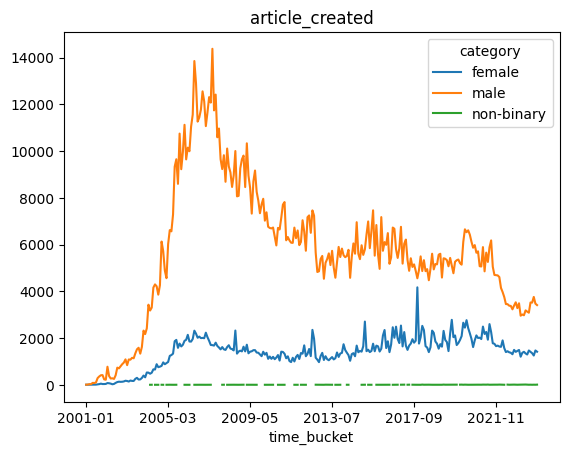

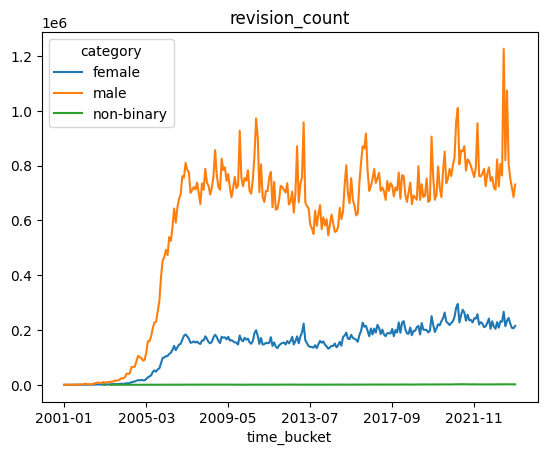

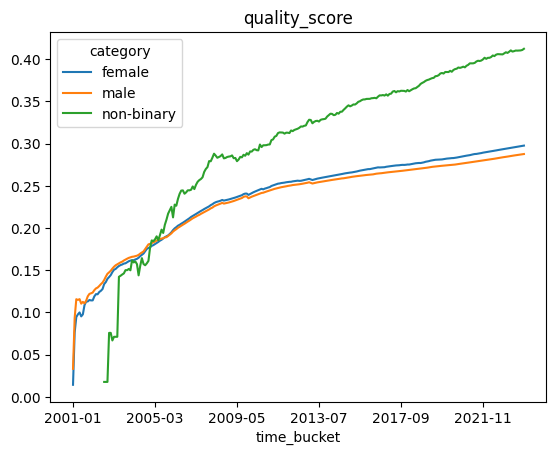

In [9]:
(en_gender
  .pivot(index="time_bucket",columns='category',values='article_created')
  .plot(y=["female", "male", "non-binary"],title='article_created')
)
(en_gender
  .pivot(index="time_bucket",columns='category',values='revision_count')
  .plot(y=["female", "male", "non-binary"],title='revision_count')
)
(en_gender
  .pivot(index="time_bucket",columns='category',values='quality_score')
  .plot(y=["female", "male", "non-binary"],title='quality_score')
)

### Quantile metrics

The `quantiles` struct contains percentiles for content gap metrics metrics. 

Example: For articles about women and men for English wikipedia, plot the median (50th percentile), the 75th percentile and the 95th percentile of article quality scores. 

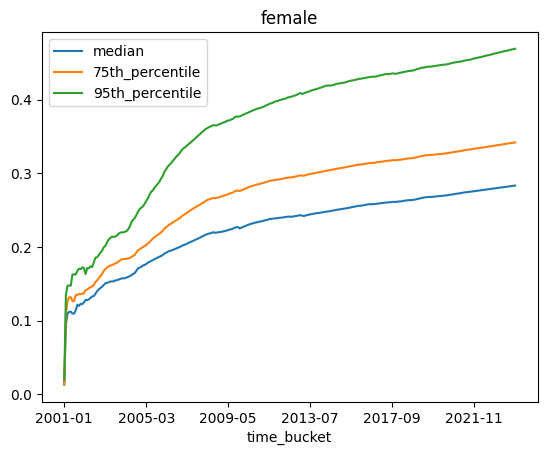

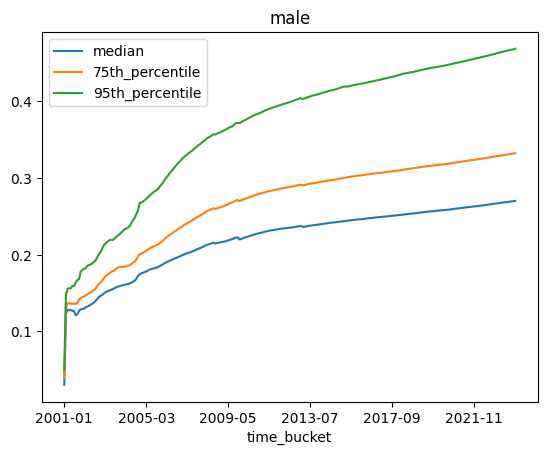

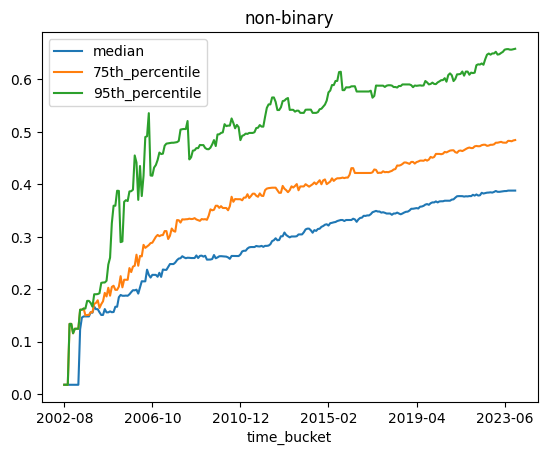

In [13]:
# The percentiles are generated for [0.05, 0.25, 0.5, 0.75, 0.95]
fields = {
    'median': F.col('quantiles.quality_score.median'),
    '75th_percentile': F.col('quantiles.quality_score.75th_percentile'),
    '95th_percentile': F.col('quantiles.quality_score.95th_percentile'),
}
fields = { n: c.alias(n) for n,c in fields.items() }

categories = ['female', 'male', 'non-binary']
for category in categories:
    (spark.table("content_gap_metrics.by_category")
        .where(f"wiki_db='enwiki' and content_gap='gender' and category='{category}'")
        .select('time_bucket', 'category', *fields.values())
        .orderBy('time_bucket')
    ).toPandas().plot(x='time_bucket', y=fields.keys(),title=category)


### Normalized metrics

The metrics dataset is also available in a normalized version. Aggregated to have only a single row per content gap category, with the timeseries for all metric features (e.g. pageviews, revision count, etc.) stored in nested maps. This format is useful when building tools to explore or visualize content gap metrics. The default (denormalized) version is likely more useful when the knowledge gaps metrics are input to another analysis. 



In [14]:
spark.table("content_gap_metrics.normalized").printSchema()

en_gender = spark.table("content_gap_metrics.normalized").where("content_gap='gender' and wiki_db='enwiki'").collect()
assert len(en_gender)==1, "normalized data contains a single entry per content gap and wiki"
metrics = en_gender[0].by_category
female_good_articles = metrics["female"]["standard_quality_count"]
for tb in ["2022-06", "2023-06"]:
    print(f'standard quality count in {tb} : {female_good_articles[tb]}')

root
 |-- wiki_db: string (nullable = true)
 |-- by_category: map (nullable = true)
 |    |-- key: string
 |    |-- value: map (valueContainsNull = true)
 |    |    |-- key: string
 |    |    |-- value: map (valueContainsNull = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: double (valueContainsNull = true)
 |-- by_content_gap: map (nullable = true)
 |    |-- key: string
 |    |-- value: map (valueContainsNull = true)
 |    |    |-- key: string
 |    |    |-- value: double (valueContainsNull = true)
 |-- content_gap: string (nullable = true)



standard quality count in 2022-06 : 87961.0
standard quality count in 2023-06 : 97069.0


## Content gap features

The content gap features associated with articles is stored in `content_gap_metrics.content_gap_features

In [15]:
spark.table("content_gap_metrics.content_gap_features").printSchema()

root
 |-- wiki_db: string (nullable = true)
 |-- page_id: long (nullable = true)
 |-- qitem_id: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- is_human: boolean (nullable = true)
 |-- gender: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- gender_qid: string (nullable = true)
 |    |    |-- gender: string (nullable = true)
 |-- sexual_orientation: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- sexual_orientation_qid: string (nullable = true)
 |    |    |-- sexual_orientation: string (nullable = true)
 |-- geographic: struct (nullable = true)
 |    |-- geospatial_model: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- geocoordinates: struct (nullable = true)
 |    |    |    |    |-- lat: float (nullable = true)
 |    |    |    |    |-- lon: float (nullable = true)
 |    |    |    |-- geocode: struct (nullable = true)
 |    |    |    |   

Example: Create a dataset of articles about women who are associated with the 1970s and the country of France. 
    
    

In [16]:

features = spark.table("content_gap_metrics.content_gap_features").cache()

In [18]:

gendered = "female"
@F.udf(returnType='boolean')
def filter_gender(gender):
    if gender:
        for g in gender:
            if g.gender == gendered:
                return True
    return False


country = "FR"
@F.udf(returnType='boolean')
def filter_region(geographic):
    if geographic and geographic.cultural_model:
        for g in geographic.cultural_model:
            if g.iso_code == country:
                return True
    return False


min_year, max_year = 1970, 1979
@F.udf(returnType='boolean')
def year_range(time_feature):
    if time_feature:
        for prop, year in time_feature:
            if year and min_year <= year <= max_year:
                return True
    return False

@F.udf(returnType='string')
def url(wiki,title):
    return f"https://{wiki[:-4]}.wikipedia.org/wiki/{title}"

(features
   .where(filter_region("geographic"))
   .where(filter_gender("gender"))
   .where(year_range("time"))
   .select("qitem_id", url("wiki_db","page_title").alias("url"))
   .show(truncate=False)
)



+---------+-----------------------------------------------------------+
|qitem_id |url                                                        |
+---------+-----------------------------------------------------------+
|Q3675761 |https://it.wikipedia.org/wiki/Christine_Eyene              |
|Q3471935 |https://rw.wikipedia.org/wiki/Sandra_Nkaké                 |
|Q3081230 |https://en.wikipedia.org/wiki/Francine_Landre              |
|Q30343220|https://ru.wikipedia.org/wiki/Пети,_Валери                 |
|Q64027172|https://fr.wikipedia.org/wiki/Marie_Guinet                 |
|Q668089  |https://en.wikipedia.org/wiki/Laïsa_Lerus                  |
|Q19366149|https://es.wikipedia.org/wiki/Anne-Line_Poncet             |
|Q5529240 |https://en.wikipedia.org/wiki/Gaëlle_Méchaly               |
|Q30335035|https://pl.wikipedia.org/wiki/Laurence_Vanceunebrock-Mialon|
|Q433882  |https://it.wikipedia.org/wiki/Catherine_Marsal             |
|Q2977534 |https://fr.wikipedia.org/wiki/Claude_Génia           

## Metric Features

The "metric features"  are often used and common metrics used within Wikipedia projects, e.g. number of pageviews, number of revisions, number of articles created, etc. The knowledge pipeline uses this "metric features" dataset as input to compute the content gap metrics. The metric features dataset is stored in the  `content_gap_metrics.metric_features` hive table. 

In [19]:
metric_features = spark.table("content_gap_metrics.metric_features")
metric_features.printSchema()

root
 |-- wiki_db: string (nullable = true)
 |-- page_id: long (nullable = true)
 |-- time_bucket: string (nullable = true)
 |-- article_created: integer (nullable = true)
 |-- pageviews: long (nullable = true)
 |-- quality_score: float (nullable = true)
 |-- standard_quality: integer (nullable = true)
 |-- page_revision_count: long (nullable = true)



Example: For the [List of highest-grossing Indian films](https://en.wikipedia.org/wiki/List_of_highest-grossing_Indian_films), plot the normalized timeseries for pageviews, revision count, and quality scores.

wiki_db   page_id time_bucket  article_created  pageviews  quality_score  \
0    enwiki  37650258     2012-11              1.0        NaN       0.228643   
1    enwiki  37650258     2012-12              NaN        NaN       0.277002   
2    enwiki  37650258     2013-01              NaN        NaN       0.319829   
3    enwiki  37650258     2013-02              NaN        NaN       0.315275   
4    enwiki  37650258     2013-03              NaN        NaN       0.305694   
..      ...       ...         ...              ...        ...            ...   
129  enwiki  37650258     2023-08              NaN  1007727.0       0.682035   
130  enwiki  37650258     2023-09              NaN  2511874.0       0.683799   
131  enwiki  37650258     2023-10              NaN  1369558.0       0.683535   
132  enwiki  37650258     2023-11              NaN   862906.0       0.741515   
133  enwiki  37650258     2023-12              NaN  2498169.0       0.739384   

     standard_quality  page_revision_count  
0                   0                   50  
1                   0                   53  
2                   0                   67  
3                   0                  141  
4                   0                   71  
..                ...                  ...  
129                 1                  170  
130                 1                  186  
131                 1                   81  
132                 1                  128  
133                 1                  111  

[134 rows x 8 columns]

<Axes: xlabel='time_bucket'>

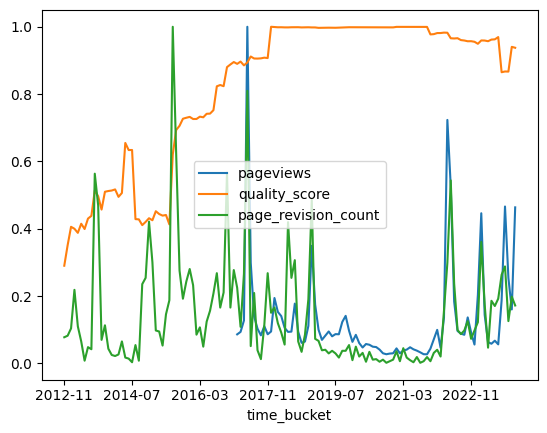

In [20]:
import pandas as pd

# List of highest-grossing Indian films
p = metric_features.where("page_id=37650258 AND wiki_db='enwiki'").orderBy('time_bucket').toPandas()

display(p)

# Normalize metrics so that we can plot them in a single graph
p[['pageviews', 'quality_score', 'page_revision_count']]  = p[['pageviews', 'quality_score', 'page_revision_count']] / p[['pageviews', 'quality_score', 'page_revision_count']].max()
p.plot('time_bucket',["pageviews","quality_score","page_revision_count"])